### 1. Introduction

* Doge Insulation Inc supplies insulation to construction projects. The firm own 4 trucks, with a load (carrying) of 40,000 lbs each. The logistics analyst must make routes for the next days deliveries. The customer coordinates and delivery quantity (in lbs) is given in the table **'Routing_for_Doge_Insulation.xlsx'**.


* All deliveries must originate from the warehouse located at X=460, Y=720. All 4 trucks are availble at the warehouse.


* Other relevant data: Vehicle speed: 70, max work hours per day: 12, max driving hours:11, max distance (70*11)840, cost $/mi=1.3, vehicle capacity: 40,000 lbs.


In [121]:
import pandas as pd
df = pd.read_excel('Routing_for_Doge_Insulation.xlsx')
df

,Customers,X,Y,Order
0,1,220,800,3000
1,2,240,720,31500
2,3,470,790,16500
3,4,670,860,6000
4,5,540,730,4500
5,6,630,680,6750
6,7,420,570,3750
7,8,370,490,6000
8,9,330,500,7500
9,10,250,450,9000


#### 1.1 Capacitated Vehicle Routing Problem (CVRP)


* A warehouse must supply isulation project to 15 customers.

* Each customer has a known demand.

* 4 vehicles (with limited capacity 40,000 lbs) must deliver to all customers.

* A driver can drive up to 840 mi

* The goal is to minimize total travel cost (or distance), subject to constraints of  capacity and working hours and routing feasibility.


#### 1.2 Set parameters



N={1,...,n}: set of client nodes (0 is the depot)

V={0,1,...,n}: set of vetics (or nodes) (0 is the warehouse, others are client)

A: set of arcs, with A={ (i, j) $\in$ $V^2$: i !=j}  

$c_{ij}$: distance from node i to j

$d_i$: demand of customer i (with $d_0$=0)

Q: capacity of each vehicle

q: is the amount that has to be delivered to customer i $\in$ N

K: the number of vehicles

L: max allowed miles a driver per day

#### 1.2 Formulation


**Decision Variables**

$x_{ij}$: 1 if the vehicle travels directly from i to j, 0 otherwise

$u_i$: load (or cumulative load) at company node i, used for subtour elimination. Without this 
variable, we cannot make circle routes

$l_i$: miles (or cumulative miles) at company node i, used for subtour elimination. Without this 
variable, we cannot make circle routes

$l_{i0}$: miles (or cumulative miles) at warehouse from company node i, used for subtour elimination. Without this 
variable, we cannot make circle routes

**Objective Function**

$$
min \sum_{i,j \in A} x_{ij}c_{ij} 
$$


**Constraints**

Each client is visited exactly once:

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1   -----       i \in N
$$

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1    -----      j \in N
$$

Vehicle starts and ends at the depot::

$$
\sum_{j \in N,\, j \ne 0} x_{0j} \le K  
$$

$$
\sum_{i \in N,\, i \ne 0} x_{i0} \le K   
$$

Subtour Elimination (MTZ formulation):
$$
if\quad x_{ij} = 1  \Rightarrow  u_i + q_j = u_j \quad\quad  i, j \in A: j\ne0, i\ne0
$$

$$
q_i \le u_i \le Q  \quad \quad i \in N
$$

$$
if\quad x_{ij} = 1  \Rightarrow  l_i + c_{ij} = l_j \quad\quad  i, j \in A: j\ne0, i\ne0
$$

$$
if\quad x_{i0} = 1  \Rightarrow  l_i + c_{i0} = l_{i0} \quad\quad  i \in N
$$

$$
0 < l_i < L  \quad\quad i \in N
$$

$$
c_{i0} \le l_{i0} \le L  \quad\quad i \in N
$$

Binary decision variable:

$$
x_{ij} \in {0,1} \quad\quad i,j \in A
$$




#### 1.3 Explanation on Subtour Elimination



**If arc (i, j) is used ($x_{ij}$ = 1), then enforce $u_i$ + $q_j$ = $u_j$**

it is equivalent to the statement as follows:

$u_i$ + $q_j$ - $u_j$ <= M(1-$x_{ij}$)

$u_i$ + $q_j$ - $u_j$ >= M(1-$x_{ij}$)

Similarly, 

**if arc (i, j) is used ($x_{ij}$ = 1), then enforce $l_i$ + $c_{ij}$ = $l_j$**

**if arc (i, 0) is used ($x_{i0}$ = 1), then enforce $l_i$ + $c_{i0}$ = $l_{i0}$**

They prevent the formation of **subtours** — smaller cycles that don’t include the wearhouse or don’t cover all customers.

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict
from itertools import cycle
import time

### 2. Create coodinators for clients

In [123]:
df

,Customers,X,Y,Order
0,1,220,800,3000
1,2,240,720,31500
2,3,470,790,16500
3,4,670,860,6000
4,5,540,730,4500
5,6,630,680,6750
6,7,420,570,3750
7,8,370,490,6000
8,9,330,500,7500
9,10,250,450,9000


In [124]:
xc =[460] + df['X'].tolist()
yc =[720] + df['Y'].tolist()


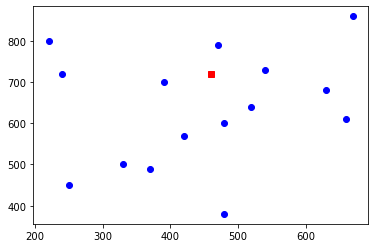

In [125]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')    
plt.show()

### 3. Modeling

In [208]:
n = 15
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): round(np.hypot(xc[i]-xc[j], yc[i]-yc[j]), 2) for i, j in A}
Q = 40000
orders = df['Order'].tolist()
q = {i+1: order  for i, order in enumerate(orders)}
K = 4
L = 840
Zero = 0

Vehicle starts and ends at the depot::

$$
\sum_{j \in N,\, j \ne 0} x_{0j} \le K  
$$

$$
\sum_{i \in N,\, i \ne 0} x_{i0} \le K   
$$

Subtour Elimination (MTZ formulation):
$$
if\quad x_{ij} = 1  \quad\quad \Rightarrow\quad\quad  u_i + q_j = u_j \quad\quad  i, j \in A: j\ne0, i\ne0
$$

$$
q_i \le u_i \le Q  \quad \quad i \in N
$$

$$
if\quad x_{ij} = 1  \quad\quad \Rightarrow \quad\quad  l_i + c_{ij} = l_j \quad\quad  i, j \in A: j\ne0, i\ne0
$$

$$
if\quad x_{i0} = 1  \quad\quad \Rightarrow \quad\quad  l_i + c_{i0} = l_{i0} \quad\quad  i \in N
$$

$$
if\quad x_{0j} = 1  \quad\quad \Rightarrow \quad\quad  l_j = c_{0j} \quad\quad  i \in N
$$

$$
if\quad x_{i0} = 0  \quad\quad \Rightarrow \quad\quad   l_{i0} = 0 \quad\quad  i \in N
$$

$$
0 < l_i < L  \quad\quad i \in N
$$

$$
c_{i0} \le l_{i0} \le L  \quad\quad i \in N
$$


In [209]:
model = Model('CVRP')
x = model.addVars(A, vtype=GRB.BINARY, name='x')
u = model.addVars(N, lb=0, vtype=GRB.CONTINUOUS, name='u')
l = model.addVars(N, lb=0, vtype=GRB.CONTINUOUS, name='l')
l_0 = model.addVars(N, lb=0, vtype=GRB.CONTINUOUS, name='l_0')
# l_0: miles (or cumulative miles) at warehouse from company node i


model.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A), GRB.MINIMIZE)

model.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
model.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)

model.addConstr(quicksum(x[0, j] for j in N) <= K )
model.addConstr(quicksum(x[i, 0] for i in N) <= K)

model.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i != 0 and j != 0)
model.addConstrs((x[i, j] == 1) >> (l[i]+c[i, j] == l[j])
               for i, j in A if i != 0 and j != 0)
model.addConstrs((x[i, 0] == 1) >> (l[i]+c[i, 0] == l_0[i])
               for i in N)
model.addConstrs((x[0, j] == 1) >> (l[j] == c[0, j])
               for j in N)
model.addConstrs((x[i, 0] == 0) >> (l_0[i] == 0)
               for i in N)

model.addConstrs(u[i] >= q[i] for i in N)
model.addConstrs(u[i] <= Q for i in N)

model.addConstrs(l[i] >= Zero for i in N)
model.addConstrs(l[i] <= L for i in N)


model.addConstrs((x[i, 0] == 1) >> (l_0[i] >= c[i, 0]) for i in N)
model.addConstrs((x[i, 0] == 1) >> (l_0[i] <= L) for i in N)

{1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>,
 11: <gurobi.GenConstr *Awaiting Model Update*>,
 12: <gurobi.GenConstr *Awaiting Model Update*>,
 13: <gurobi.GenConstr *Awaiting Model Update*>,
 14: <gurobi.GenConstr *Awaiting Model Update*>,
 15: <gurobi.GenConstr *Awaiting Model Update*>}

#### 3. 1 Set parameter to allow stoping early to get good solution instead of optimal solution

In practical optimization, especially for large MIPs, exact optimality is often too expensive. Setting a small MIPGap and reasonable TimeLimit helps balance solution quality and performance. Gurobi stops as soon as either criterion is satisfied, so they serve as complementary early stopping rules.

In [210]:
# You can stop early if you're 10% away from the optimal solution.
# model.Params.MIPGap = 0.1  # Set a 1% optimality gap
# model.Params.TimeLimit = 60  # # Stop solving after 30 seconds

start = time.time()

model.optimize()

end = time.time()
runtime = end - start

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 19.6.0 19H2026)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 92 rows, 285 columns and 540 nonzeros
Model fingerprint: 0xee487929
Model has 495 general constraints
Variable types: 45 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
  GenCon rhs range [4e+01, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve added 960 rows and 164 columns
Presolve time: 0.09s
Presolved: 1052 rows, 449 columns, 5544 nonzeros
Variable types: 219 continuous, 230 integer (230 binary)

Root relaxation: objective 1.988101e+03, 159 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

### Print results

In [211]:
# Print parameter values
print("\n--- Solver Parameters ---")
print("MIPGap (target):", model.Params.MIPGap)
print("TimeLimit (target):", model.Params.TimeLimit)

# Print final solution details
print("\n--- Solver Results ---")
if model.SolCount > 0:
    print("Final Objective Value:", round(model.ObjVal, 2))
    print(f"Number of solutions found: {model.SolCount}")
    print("Final MIP Gap Achieved:", round(model.MIPGap, 2))
    print(f"Final Run Time Achieved: {round(runtime, 1)}s")
else:
    print("No feasible solution found.")


--- Solver Parameters ---
MIPGap (target): 0.0001
TimeLimit (target): inf

--- Solver Results ---
Final Objective Value: 2797.19
Number of solutions found: 10
Final MIP Gap Achieved: 0.0
Final Run Time Achieved: 10.5s


### Visualize results

In [212]:
from collections import defaultdict

active_arcs = [(i, j) for i, j in A if x[i, j].X == 1]

active_arcs_dic = defaultdict(list)
for i, j in active_arcs:
    active_arcs_dic[i].append((i, j))

route_circles = []
for i, j in active_arcs_dic[0]:
    route_circles.append([(i, j)])
    start, end = j, active_arcs_dic[j][0][1]
    while end != 0:
        route_circles[-1].append((start, end))
        start, end = end, active_arcs_dic[end][0][1]
    else:
        route_circles[-1].append((start, end))
route_circles 

[[(0, 1), (1, 2), (2, 0)],
 [(0, 5), (5, 6), (6, 13), (13, 4), (4, 3), (3, 0)],
 [(0, 14), (14, 10), (10, 9), (9, 8), (8, 7), (7, 0)],
 [(0, 15), (15, 12), (12, 11), (11, 0)]]

In [213]:
trucks = {}
for circle in route_circles:
    last_node = circle[-1][0]
    total_distance = round(l_0[last_node].X, 0)
    total_load = round(u[last_node].X, 0)
    trucks[(total_distance, total_load)] = circle

trucks

# take truck 1 for example
# truck 1 carries 34,500 lbs of construction projects to start the route from warehouse, 
# deliver the required products to customer 1, 2 in sequence, then goes back to warehouse 
# with empty load. The total distance of the circle route is 555 miles

{(555.0, 34500.0): [(0, 1), (1, 2), (2, 0)],
 (793.0, 36750.0): [(0, 5), (5, 6), (6, 13), (13, 4), (4, 3), (3, 0)],
 (744.0, 33000.0): [(0, 14), (14, 10), (10, 9), (9, 8), (8, 7), (7, 0)],
 (705.0, 34500.0): [(0, 15), (15, 12), (12, 11), (11, 0)]}

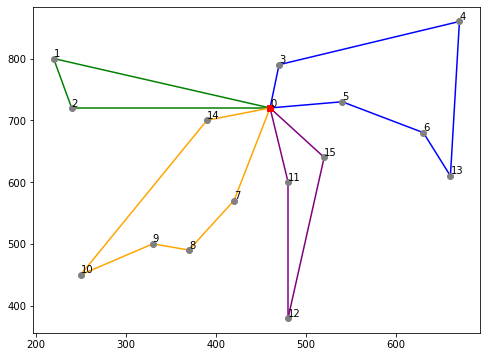

In [214]:

colors = cycle(['green', 'blue', 'orange', 'purple', 'magenta', 'pink', 'cyan'])

plt.figure(figsize=(8, 6))

for circle in route_circles:
    color = next(colors)
    for i, j in circle:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=color, zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='grey')

for i in V:
    plt.text(xc[i], yc[i], V[i], ha='left', va='bottom')
    
plt.show()

In [215]:
model.printAttr('X')


    Variable            X 
-------------------------
      x[0,1]            1 
      x[0,5]            1 
     x[0,14]            1 
     x[0,15]            1 
      x[1,2]            1 
      x[2,0]            1 
      x[3,0]            1 
      x[4,3]            1 
      x[5,6]            1 
     x[6,13]            1 
      x[7,0]            1 
      x[8,7]            1 
      x[9,8]            1 
     x[10,9]            1 
     x[11,0]            1 
    x[12,11]            1 
     x[13,4]            1 
    x[14,10]            1 
    x[15,12]            1 
        u[1]         3000 
        u[2]        34500 
        u[3]        36750 
        u[4]        20250 
        u[5]         4500 
        u[6]        11250 
        u[7]        33000 
        u[8]        29250 
        u[9]        23250 
       u[10]        15750 
       u[11]        34500 
       u[12]        29250 
       u[13]        14250 
       u[14]         6750 
       u[15]        11250 
        l[1]       252.98 
 